In [3]:
import numpy as np
from astropy import cosmology 
from astropy import constants as const, units as u
from astropy.cosmology import Planck15 as P

from scipy import integrate

%pylab inline

Populating the interactive namespace from numpy and matplotlib


The most naive thing one can do, is assume some fraction $f$ of all matter lives in compact halos, and a lensing optical depth can be computed as follows:

\begin{equation}
\tau(z_s) = \frac{1}{4\pi}\int n(z_l)\,\pi\,\theta^2_E\,dV(z_l)\,\,\,\,\,\,\,\,\,\,\,(1)
\label{}
\end{equation}

$$
    \tau(z_s) = \frac{c}{H_0} \int_0^{z_s}dz\,\frac{G f \Omega_m}{c^2}
            \frac{D_{ls}}{D_l D_s} \times \frac{(1+z)^2}{\sqrt{(1+z)^3\Omega_m + \Omega_\lambda}}
            \,\,\,\,\,\,\,\,\,\,\,(2)
$$

This equation integrates over all lenses between the observer and the source assuming $n = f \Omega_m \rho_c/M$, $\rho_c = 3H_0^2/(8\pi G)$

We are effectively assuming that the dark matter exists in primordial black holes or MACHOS

We can also parameterize a mass function as follows:

$$
n(M, z_l)\equiv\frac{dn}{dM} = f(\sigma) \frac{\rho_{crit}\Omega_m}{M} \frac{d ln \sigma^{-1}}{dM}
$$

where the numerical factor in front is 

$$
f(\sigma)_{PS} = \sqrt{\frac{2}{\pi}} exp\left (-\delta_c^2 / 2\sigma^2 \right)\,\,\,\,\,\,\, \delta_c = 1.68
$$

for Press-Schecter, and something nastier for Sheth-Tomer (see http://astronomy.nmsu.edu/aklypin/COSMOLOGY/HaloMassFunction.pdf)

Suppose we only want to focus on dark matter sub-halos, whether field halos along the line of site, or in a lensing galaxy.



$$
\tau\,(z_s, M_{min}, M_{max}) = \int_0^{z_s}\!\!\int^{M_{min}}_{M_{max}} \,\,\frac{dV}{dz_l} n(M, z_l) \,\,\pi \theta^2(M, z_l, z_s)\,\,\mathrm{d}M \mathrm{d}z_l
$$

In [23]:
def D_eff(zl, zs):
    """ Calculate the effective lensing distance 
    for a lens at zl and a source at zs.
    """
    Ds = P.angular_diameter_distance(zs)
    Dl = P.angular_diameter_distance(zl)
    Dls = P.angular_diameter_distance_z1z2(zl, zs)
    Deff = Dls / (Dl * Ds)
    
    return Dl, Ds, Dls, Deff

def theta_ein(M, zl=0.5, zs=1, prof='ps', sigma=None):
    """ Get Einstein radius for mass M 
    in units of M_sun, lens redshift (zl), 
    and source redshift (zs) for a given 
    density profile.
    """
    M *= u.M_sun
    Dl, Ds, Dls, Deff = D_eff(zl, zs)
    
    if prof=='ps':
        print("Assuming point source mass function")
        theta = np.sqrt(4*const.G*M*Deff/const.c**2)
        
    if prof=='SIS':
        if sigma is None:
            print("Expected a velocity dispersion sigma for SIS")
            return 
        theta = 4 * np.pi / const.c**2 * (sigma*u.km/u.s)**2 * Dls / Ds
        
    if prof=='NFW':
        pass
    
    return theta.decompose()*u.rad

def tau_integrand_BH(zl, zs=1, f=1.0):
    """Get lensing optical depth integrand from Eq. 2
    assuming a fraction f of the Universe's matter in 
    compact halos or blackholes 
    
    Parameters:
    -----------
    zl : float 
        lens redshift 
    zs : float 
        source redshift 
    f  : float 
        fraction of critical mass in halos 
        
    Returns:
    --------
    Integrand"""
    M = const.M_sun # Note mass actually doesn't affect integral
    dV = P.differential_comoving_volume
    Deff = D_eff(zl, zs)[-1]
    theta_e = np.sqrt(4 * const.G * M / const.c**2 * Deff) * u.sr
    rho_crit = 3 * P.H0**2 / (8*np.pi*const.G)
    n = f * P.Om0 * rho_crit / M
    tau_int = 1/(4*np.pi*u.sr) * n * dV(zl) * np.pi * theta_e**2
    tau_int *= (u.km**2).to(u.m**2) * u.m**2/u.km**2
    return tau_int

def n_sig(zl, sig, mu=200, var=1000):
    """ For now assume redshift independence. 
    The number of halos above 10**10 solar masses is 
    6e-3 according to
    http://inspirehep.net/record/1125519/plots 
    """
    gauss = (2*np.pi*var)**-0.5*np.exp(-(sig-mu)**2/(2*var))
    gauss *= u.Mpc**-3
    gauss *= 6e-3
    gauss = gauss
    
    return gauss

def tau_integrand_SIS(zl, sig, zs=1, B=1):
    """Get lensing optical depth integrand from Eq. 2
    assuming SIS and sig vel dispersion
    
    Parameters:
    -----------
    zl : float 
        lens redshift 
    zs : float 
        source redshift 
    sig  : float 
        halo vel dispersion in km/s
        
    Returns:
    --------
    Integrand"""
    dV = P.differential_comoving_volume
    n_of_sig = n_sig(zl, sig)
    theta_e = theta_ein(1, zl=0.5, zs=1, prof='SIS', sigma=sig)
    tau_int = B * n_of_sig * np.pi*theta_e**2 * dV(zl)

    return tau_int.decompose()

def tau_integral(zs, f=1, n=1000):
    zl_arr = np.linspace(0.01, zs, n)
    tau_arr = np.zeros_like(zl_arr)
    
    for ii, zs in enumerate(zl_arr):
        val = quad(tau_integrand_BH, 0, zs, (zs, f))[0]
        tau_arr[ii] = val
        
    return zl_arr, tau_arr

In [15]:
# Mass functions http://astronomy.nmsu.edu/aklypin/COSMOLOGY/HaloMassFunction.pdf

def f_sigma(sigma, name='ps'):
    """
    """
    delta_c = 1.686

    if name=='ps':
        print("Assuming Press-Schecter")
        f = np.sqrt(2/np.pi) * delta_c/sigma * np.exp(-delta_c**2 * 0.5 / sigma**2)
    elif name=='st':
        print("Assuming Sheth-Torman")
        A = 0.3222
        a = 0.707
        p = 0.3
        f = A * np.sqrt(2*a/np.pi) * (1+(sigma**2/(a*delta_c**2))**p) * delta_c / sigma * np.exp(-a*delta_c**2/(2*sigma**2))
    else:
        print("Expecting either ps or st as name")
        return f
    
    return f

def n_of_M(sigma, M, name='ps'):
    """ Calculate the differential mass function 
    of halos in the Universe as a function of sigma (RMS density fluctuations) 
    and M
    """
    f = f_sigma(sigma, name=name)
    rho_crit = 3 * P.H0**2 / (8*np.pi*const.G)
    dlogsiginv_dm = 1
    print("Haven't implemented dlogsiginv_dm yet!")
    n_of_M_ = f * P.Om0 * rho_crit / M * dlogsiginv_dm
    return n_of_M_.to(u.Msun/u.Mpc**3)
    
def mass_func_integrand(zl,zs=1.0,M=1e6):
    """ Get differential number of lenses at mass M
    at zl for source at zs. 
    """
    Amp_M6 = 1e3 * u.Mpc**3 # amplitude of mass number density for 1e6 solar mass halos
    dV = P.differential_comoving_volume(zl)
    N = Amp_M6 * (M/1e6)**-0.75 * np.pi * theta_ein(M, prof='ps', zl=zl, zs=zs)**2 * dV
    return N

In [356]:
# Integrate tau_integrand_BH (Eq. 2) 
# for different assumptions about the fraction of 
# the Universe's critical density in compact halos

zls = np.linspace(0.001, 3, 150)
I1,I2,I3=[],[],[]

for zz in zls:
    I1.append(quad(tau_integrand_BH, 0, zz, args=(zz, 0.3))[0])

for zz in zls:
    I2.append(quad(tau_integrand_BH, 0, zz, args=(zz, 0.03))[0])

for zz in zls:
    I3.append(quad(tau_integrand_BH, 0, zz, args=(zz, 0.0003))[0])

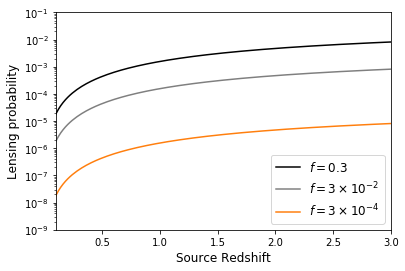

In [358]:
plot(zls, I1, color='k')
plot(zls, I2, color='k', alpha=0.5)
plot(zls, I3, color='C1')

semilogy()
xlim(0.1, 3.0)
ylim(1e-9, 0.1)
xlabel('Source Redshift', fontsize=12)
ylabel('Lensing probability', fontsize=12)
legend([r'$f=0.3$', r'$f=3\times10^{-2}$', r'$f=3\times10^{-4}$'], fontsize=12)

Another simple thing we can do, is assume each halo is assume each halo is an SIS and is parameterized only by its velocity dispersion. 

\begin{equation}
    \tau(z_s) = \int_0^{z_s} dV(z_s) \int_0^\infty d\sigma \frac{dn}{d\sigma} \times B \pi\theta_E^2(\sigma) \,\,\,\,\,\,\,\,\,\,\,(3)
\end{equation}

This equation integrates over all lenses between us and the source, 
and over all possible velecocity dispersions. Try using the function "theta_ein(M, zl=0.5, zs=1, prof='SIS', sigma=200)". Here B is magnification bias, but I will ignore that for now.

For my own clarity, I rewrite that integral as:

\begin{equation}
    \tau(z_s) = \int_0^{z_s}\!\!\int_0^\infty B \frac{dn(z_l)}{d\sigma} \times \pi\theta_E^2(z_l, z_s, \sigma) \, \,d\sigma dV(z_l) \,\,\,\,\,\,\,\,\,\,\,(3)
\end{equation}


Note: this equation comes from Eq. 30 in https://arxiv.org/pdf/1907.06830.pdf

In [468]:
zss = np.logspace(-1, 1, 50)
tau_arr_SIS = []

for zs in zss:
    val = integrate.dblquad(tau_integrand_SIS, 0, 500, lambda x: 0, lambda x: zs)[0]
    tau_arr_SIS.append(val)

Text(0, 0.5, 'Lensing probability')

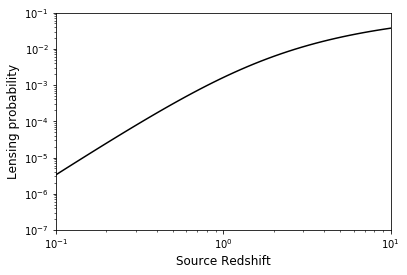

In [473]:
plot(zss, tau_arr_SIS, color='k')
loglog()
xlim(0.1, 10.0)
ylim(1e-7, 0.1)
xlabel('Source Redshift', fontsize=12)
ylabel('Lensing probability', fontsize=12)

We do not only care about the lensing probability as a function of redshift, we 
also care about the number of detectable FRBs at that redshift. To compute that 
we need the following integral for the detection rate of lensed FRBs:

$$
\mathcal{R}_{tot} = \int_0^{z_{max}} \tau(z_s)\, \mathcal{R}(z_s)\, dz
$$

where $\mathcal{R}(z_s)$ is the observer-frame rate of FRBs emitted at $z_s$ and is 
given by the following,

$$
\mathcal{R}(z_s) = \int_0^{z_{max}} \frac{1}{1+z} \frac{dV}{dz} \rho(z) \int_{L_{min}}^\infty n(L)\,dL\,dz
$$

where $\rho(z)$ is the comoving number density of FRBs emitted at $z$, the $1+z$ is due 
to the cosmic time dilation of the event rate, and $n(L)$ is the source luminosity function. 
Crucially, $L_{min}=L_{min}(z, S_{min}, B)$, and is the minimum detectable luminosity 
as a fucniton fo redshift, survey brightness threshold, and magnification bias. 


Assuming FRBs trace the star forming rate
Assuming FRBs trace the star forming rate


Text(0.5, 1.0, 'FRBs emitted per $z$')

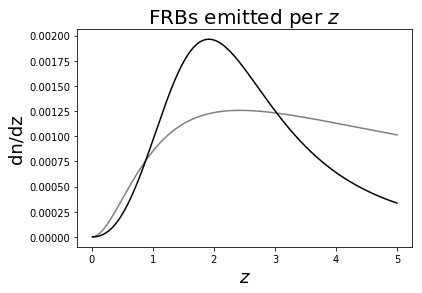

In [28]:
def r_of_z(z, name='constant'):
    """ Get the rate of FRBs 
    per redshift bin, z. 
    """    
        
    if name=='constant':
        rho_of_z = 1.0
    elif name=='sfr':
        print("Assuming FRBs trace the star forming rate")
        rho_of_z = (1+z)**2.5 / (1 + ((1+z)/2.9)**5.6)
    
    r_of_z = rho_of_z * P.differential_comoving_volume(z)
    return r_of_z

z = np.linspace(0.01, 5, 1000)
plot(z, r_of_z(z)/r_of_z(z).sum(), color='k', alpha=0.5)
plot(z, r_of_z(z, name='sfr')/r_of_z(z, name='sfr').sum(), color='k')
xlabel('$z$', fontsize=18)
ylabel('dn/dz', fontsize=18)
title('FRBs emitted per $z$', fontsize=20)